# Import libraries

In [177]:
import os
import sys
import datetime
import hdbscan
from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()
disease = "ms"
scenario = "abyss"
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Paths

In [126]:
path_input = glob.PATH_GENO + f"/04_low_P_snps"

In [127]:
combined_geno = pd.read_pickle(path_input + f"/low_p_geno.pkl")
combined_maf = pd.read_pickle(path_input + f"/low_p_maf.pkl")

In [128]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in combined_geno.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = combined_geno[cols]

In [129]:
# Split into separate DataFrames based on chromosome
chromosome_maf_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_maf_dfs[chromosome] = combined_maf[cols]

# Order in LD blocks

In [130]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random
from math import floor
from collections import Counter

In [140]:
snp_ids = []
chroms = []
labels = []
PC1s = []
PC2s = []
snps_array = []
for chrom_key in chromosome_dfs.keys():
    genos = chromosome_dfs[chrom_key].T
    genos.columns = genos.columns.astype(str)
    nr_snps_in_genos = genos.shape[0]
    
    num_clus = 6
    if num_clus > nr_snps_in_genos:
        num_clus = nr_snps_in_genos
    else:
        pass
    n_components = 1
    if nr_snps_in_genos < n_components:
        n_components = nr_snps_in_genos

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(genos)
    
    # Perform PCA with n components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df_scaled)
    pc_columns = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)
    
    # Apply classical K-Means clustering
    #clf = KMeans(n_clusters=num_clus, n_init=10, random_state=0)
    #clf.fit_predict(np.array(df_pca))
    #cluster_labels = clf.labels_
    
    # Apply HDBSCAN for clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # you can adjust the min_cluster_size as needed
    cluster_labels = clusterer.fit_predict(np.array(df_pca))
    
    # Assign cluster labels to genotypic data
    genos['clusters'] = cluster_labels

    # Reindex both DataFrames based on row order
    temp = genos.reset_index(drop=True)
    df_pca = df_pca.reset_index(drop=True)
    
    # Concatenate them again
    merged_df = pd.concat([temp, df_pca[pc_columns]], axis=1)
    
    # Set the index of merged_df to match the index of genos
    merged_df.index = genos.index
    genos = merged_df

    for num in genos.clusters.unique():
        to_save = genos.loc[genos['clusters'] == num]
        to_save_snps = to_save.drop(columns=['clusters'] + pc_columns).T
        to_save_PCs = to_save[pc_columns].T

        for snp_id in to_save_snps:
            snp_ids.append(snp_id)
            chroms.append(chrom_key)
            labels.append(f"{chrom_key}_{num}")
            PC1s.append(to_save_PCs.loc['PC1'][snp_id])
            try:
                PC2s.append(to_save_PCs.loc['PC2'][snp_id])
            except:
                PC2s.append(0)
        snps_array.append(to_save_snps)

In [132]:
to_save_snps

snp,7:50773411:A_G_G,7:105249554:C_T_C,7:22312799:C_G_C,7:116323936:G_T_G,7:37077006:C_T_T,7:8234371:C_T_T,7:68575181:A_G_G,7:37990222:A_G_G,7:96782304:A_T_A
0,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
1,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
2,1.000000,1.00000,-1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,0.000000
3,1.000000,1.00000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000
4,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
69451,1.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
69452,1.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000
69453,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
69454,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.000000


# For the sake of visual understanding plot the snps

In [133]:
data = {
    'snp': snp_ids,
    'chroms': chroms,
    'labels': labels,
    'PC1': PC1s,
    'PC2': PC2s
}
df = pd.DataFrame(data)

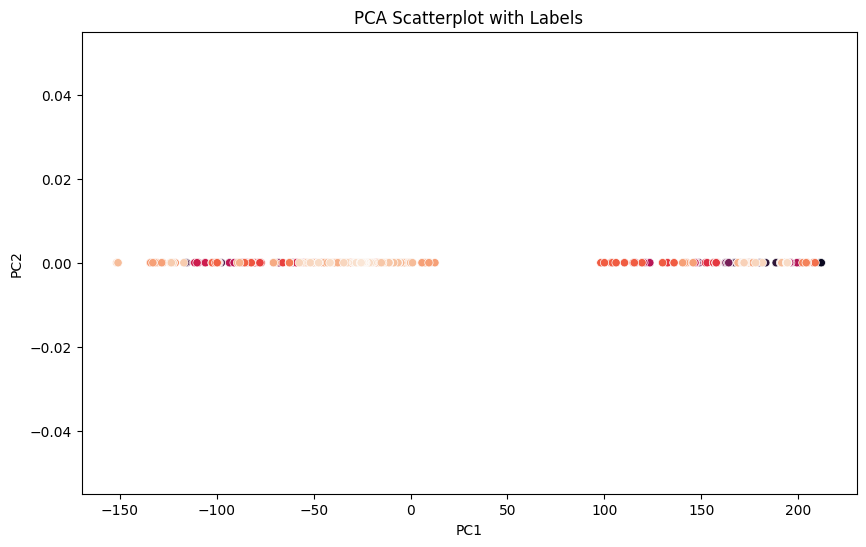

In [134]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='PC1', y='PC2', hue='labels', palette='rocket', data=df, legend= False)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

In [135]:
glob.PATH_GENO

'/mnt/d/chasm_data/genotype'

In [136]:
from chasm.glob import glob

In [137]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 3000
bin =5
path_sumstat = glob.PATH_GENO + f"/03_summary_statistics/{disease}/{scenario}"
list_of_bins = os.listdir(path_sumstat)
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_sumstat+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

In [138]:
temp_sumstat = pd.merge(sumstat, df, on='snp', how='inner')

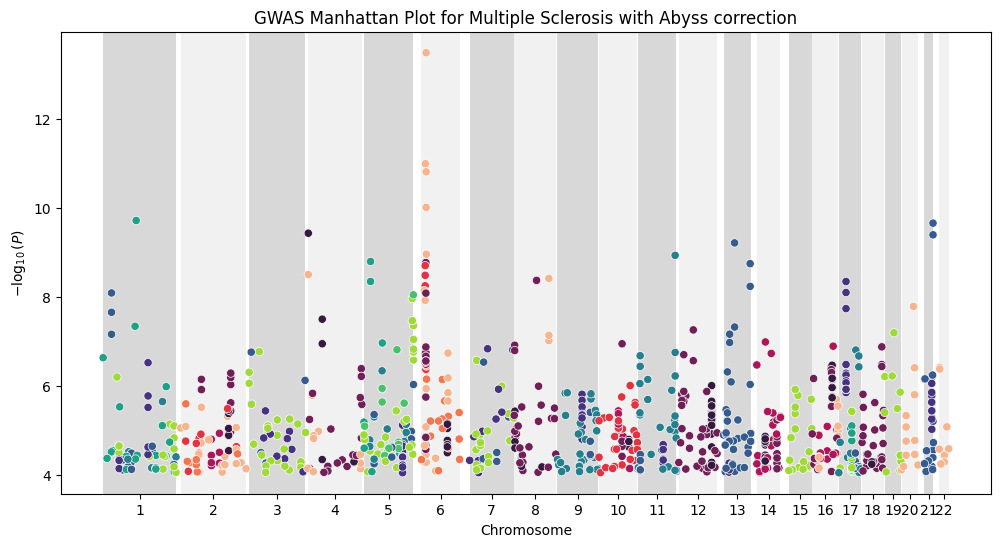

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define two palettes

even_palette = sns.color_palette("rocket")  # Lighter palette for even chromosomes
odd_palette = sns.color_palette("viridis")     # Darker palette for odd chromosomes

# Define background colors for segments
bg_color_even = "lightgrey"  # Background color for even segments
bg_color_odd = "grey"        # Background color for odd segments

# Create a figure for the Manhattan plot
plt.figure(figsize=(12, 6))

# Get start, end positions and midpoints for each chromosome
chromosomes = temp_sumstat['#CHROM'].unique()
chrom_midpoints = []
start_end_positions = []
for chrom in chromosomes:
    start = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].min()
    end = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].max()
    midpoints = (start + end) / 2
    chrom_midpoints.append(midpoints)
    start_end_positions.append((start, end))

# Add a background color for each chromosome segment
for i, (start, end) in enumerate(start_end_positions):
    chrom = chromosomes[i]
    plt.axvspan(start, end, facecolor=bg_color_even if chrom % 2 == 0 else bg_color_odd, alpha=0.3)

# Plot the data
sns.scatterplot(
    data=temp_sumstat,
    x='cumulative_pos',
    y='-logp',
    hue='labels',
    palette={label: (even_palette if int(label.split('_')[0]) % 2 == 0 else odd_palette)[int(label.split('_')[1]) % len(even_palette)] for label in temp_sumstat['labels'].unique()},
    legend=False
)

# Set title and axis labels
plt.title(f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
plt.xlabel("Chromosome")
plt.ylabel(r"$-\log_{10}(P)$")

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(chromosomes)  # Reversing the order of chromosomes
plt.xticks(chrom_midpoints, chrom_labels)

# Set the tick labels at a 45-degree angle
plt.xticks(rotation=0)

# Show the plot
plt.show()


# Create tiny feed forward models

In [168]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, concatenate, Input

In [178]:
path_pheno = glob.PATH_PHENO
pheno = pd.read_pickle(path_pheno + f"/{disease}.pkl")

In [179]:
pheno

,FID,IID,phenotype
0,4540233,4540233,1
1,2760516,2760516,0
2,3531707,3531707,1
3,5782214,5782214,0
4,2078114,2078114,1
...,...,...,...
1651,2732165,2732165,1
1652,6019519,6019519,1
1653,3019060,3019060,1
1654,1177150,1177150,1


In [176]:
path_pheno

'/mnt/d/chasm_data/phenotype'

In [174]:
from keras.layers import Dense, Input
from keras.models import Model
import numpy as np

class CustomDenseLayer(Dense):
    def __init__(self, units, betas, **kwargs):
        super().__init__(units, **kwargs)
        self.initial_weights = betas

    def build(self, input_shape):
        super().build(input_shape)
        self.set_weights([self.initial_weights.reshape(-1, 1)])

# Your snps_array and other data preparations remain the same

# Define a list to hold your sub-models
sub_models = []
genos = []

for snps_cluster in snps_array[0:2]:
    betas = np.array(snps_cluster.iloc[-1])
    geno = snps_cluster.iloc[:-1]
    genos.append(geno)
    # Create the Keras sub-model
    model_input = Input(shape=(geno.shape[1],))
    custom_layer = CustomDenseLayer(1, betas, use_bias=False)(model_input)
    sub_model = Model(inputs=model_input, outputs=custom_layer)
    
    sub_models.append(sub_model)

# Concatenate the outputs of the sub-models
concatenated_outputs = concatenate([model.output for model in sub_models])

# Add the final trainable dense layer
final_layer = Dense(1, activation='linear')(concatenated_outputs)

# Create the final model
final_model = Model(inputs=[model.input for model in sub_models], outputs=final_layer)

# Compile the final model
final_model.compile(optimizer='sgd', loss='mean_squared_error')

final_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 17)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 custom_dense_layer_2 (Cust  (None, 1)                    17        ['input_4[0][0]']             
 omDenseLayer)                                                                                    
                                                                                                  
 custom_dense_layer_3 (Cust  (None, 1)                    15        ['input_5[0][0]']       